<h1 alingn='center'> USA - Road Accident Traffic Delay Severity Prediction </h1>

This project aims to analyze the US road accident traffic delay severity by considering various matrix features and build classification model to predict the severity.

## Import Libraries

In [1]:
import pandas as pd # Used for exploratory data analysis
import numpy as np # array data processing
%matplotlib inline

# below libraries are used for plotting charts
import matplotlib as mpl 
import matplotlib.pyplot as plt
import seaborn as sns 

mpl.style.use('ggplot') # optional: for ggplot-like style

In [2]:
#library used generate map

#!conda install -c conda-forge folium=0.5.0 --yes
import folium

## About Data

The dataset has been downloaded from kaggle.com. As the orignal dataset volumn is more than 1.2 GB, unable process the data in the lab. Hence, I have extracted only the data for the year 2020 and saved the data as csv file.

Selected only the required column to reduce the data volume 

In [2]:
df = pd.read_csv('US_accident_data_2020.csv')

df_filter = df[['Severity','Start_Time','End_Time','Start_Lat', 'Start_Lng', 'Temperature(F)', 'Weather_Condition', 'Wind_Direction', 'Wind_Chill(F)', 'Humidity(%)','Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)','Precipitation(in)', 'City', 'State','Bump', 'Crossing','Junction', 'Roundabout', 'Stop']]
df_filter.head(5)

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Temperature(F),Weather_Condition,Wind_Direction,Wind_Chill(F),Humidity(%),...,Visibility(mi),Wind_Speed(mph),Precipitation(in),City,State,Bump,Crossing,Junction,Roundabout,Stop
0,3,2020-05-24 01:37:16,2020-05-24 02:06:05,42.932457,-78.766060,64.0,Cloudy,CALM,64.0,87.0,...,10.0,0.0,0.00,Buffalo,NY,False,False,False,False,False
1,2,2020-05-24 04:19:35,2020-05-24 05:03:27,43.005428,-78.948601,62.0,Light Rain,ESE,62.0,90.0,...,5.0,5.0,0.01,Grand Island,NY,False,False,False,False,False
2,2,2020-05-24 16:00:22,2020-05-24 17:17:57,42.744190,-78.842873,83.0,Partly Cloudy,SW,83.0,46.0,...,10.0,9.0,0.00,Hamburg,NY,False,False,False,False,False
3,2,2020-05-24 09:21:07,2020-05-24 09:50:36,42.013992,-70.726639,54.0,Mostly Cloudy,ENE,54.0,58.0,...,10.0,13.0,0.00,Duxbury,MA,False,False,False,False,False
4,3,2020-05-24 15:13:34,2020-05-24 15:43:04,42.380833,-71.076225,52.0,Cloudy,E,52.0,61.0,...,10.0,15.0,0.00,Charlestown,MA,False,False,False,False,False


The dataset is having lots of null values on various column. Hence filtered the null values from the dataset

The Wind Direction is having duplicate values like East&E, West&W, North&N, South&S. Replaced the values with E,W,N&S respectively

In [3]:
df_us_acc = df_filter[(~df_filter['Weather_Condition'].isnull() & ~df_filter['Wind_Speed(mph)'].isnull() & ~df_filter['Temperature(F)'].isnull() & ~df_filter['Humidity(%)'].isnull() & ~df_filter['Visibility(mi)'].isnull() & ~df_filter['Pressure(in)'].isnull() & ~df_filter['Wind_Direction'].isnull() & ~df_filter['Precipitation(in)'].isnull() & ~df_filter['Wind_Chill(F)'].isnull() )].sample(n=50000, replace=False, random_state=1).reset_index()

df_us_acc.rename(columns={'Temperature(F)':'Temperature', 'Wind_Chill(F)':'Wind_Chill', 'Humidity(%)':'Humidity','Visibility(mi)':'Visibility','Pressure(in)':'Pressure', 'Wind_Speed(mph)':'Wind_Speed','Precipitation(in)':'Precipitation'},inplace=True)


df_us_acc['Visibility'].fillna(df_us_acc['Visibility'].mean(),inplace=True)

df_us_acc['Visibility']= np.ceil(df_us_acc['Visibility'])

conv_type = {'Bump':int, 'Crossing':int, 'Junction':int,'Roundabout':int,'Roundabout':int,'Stop':int}
df_us_acc = df_us_acc.astype(conv_type)
df_us_acc['Wind_Direction'].replace({'East':'E','West':'W','South':'S','North':'N'}, inplace=True)
df_us_acc['Start_Hr_Min'] = pd.to_datetime(df_us_acc['Start_Time']).dt.hour

Let us examin the number of columns and records in the filterred dataset

Top 10 records is viewed using the head method

In [11]:
df_us_acc.head(5)

,index,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Temperature,Weather_Condition,Wind_Direction,Wind_Chill,...,Wind_Speed,Precipitation,City,State,Bump,Crossing,Junction,Roundabout,Stop,Start_Hr_Min
0,37689,2,2020-06-21 04:49:59,2020-06-21 05:51:29,33.818104,-117.876396,67.0,Cloudy,CALM,67.0,...,0.0,0.0,Anaheim,CA,0,0,0,0,0,4
1,191103,3,2020-02-07 10:39:29,2020-02-07 11:09:29,34.006943,-118.414467,59.0,Fair,CALM,59.0,...,0.0,0.0,Culver City,CA,0,0,0,0,0,10
2,175653,2,2020-01-31 13:35:10,2020-01-31 14:19:30,40.099270,-83.158310,35.0,Light Snow,NNE,35.0,...,3.0,0.0,Dublin,OH,0,0,0,0,0,13
3,375318,2,2020-03-18 18:00:23,2020-03-18 18:15:23,47.638950,-122.323280,57.0,Fair,CALM,57.0,...,0.0,0.0,Seattle,WA,0,0,0,0,0,18
4,340979,2,2020-06-13 13:23:00,2020-06-13 15:17:18,34.187034,-117.355393,82.0,Fair,WSW,82.0,...,8.0,0.0,San Bernardino,CA,0,0,0,0,0,13


The accident location has been plotted using the folim map, I have passed the State, City, Severity, Latitude and Longitude as input. Double click on the map to zoom in and click on the circle mark to get the accident location details with severity and number of accident happened in that area

In [35]:
df_grp_city = df_us_acc.groupby(['Severity','State','City']).agg(Severity_Count = ('Severity','count'), lat = ('Start_Lat','max'), lan = ('Start_Lng','max')).reset_index().sort_values('Severity_Count', ascending=False)

df_map = df_grp_city[df_grp_city['Severity_Count']> 100]
us_map = folium.Map(location=[39.75, -84.23], zoom_start=4)

for lat, lng, sev, cnt, state, city in zip (df_map['lat'], df_map['lan'], df_map['Severity'], df_map['Severity_Count'],df_map['State'],df_map['City']):
    label = 'State: {}, City: {}, Severity: {}, Accident Count: {}'.format(state, city, sev,cnt)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(us_map)  
    
# display world map
us_map

Grouped the data by Severity to get the total number of accident in each severity

In [7]:
df_sev_grp_all = df_us_acc.groupby('Severity').agg ( Severity_Count = ('Severity', 'count')).reset_index().sort_values('Severity_Count')
df_sev_grp_all = df_sev_grp_all[['Severity','Severity_Count']].sort_values('Severity_Count',ascending=False).set_index('Severity')

In [9]:
df_sev_grp_all

,Severity_Count
Severity,
2,351387
3,104953
1,25575
4,18694


Created a bar chart to visualize the accident count by severity

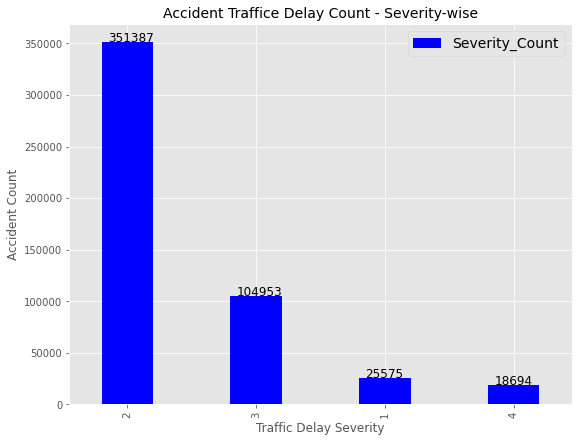

In [37]:
%matplotlib inline 
import matplotlib as mpl

df_per = round(df_sev_grp_all.div(df_sev_grp_all.sum(1), axis=0)*100,2)

ax=df_sev_grp_all.plot(kind='bar',  stacked=False, figsize=(9,7), width=.4,  color='blue') #color=[ '#5cb85c', '#5bc0de', '#d9534f']

ax.set_title("Accident Traffice Delay Count - Severity-wise", fontsize="14")
ax.set_xlabel("Traffic Delay Severity", fontsize=12)
ax.set_ylabel("Accident Count", fontsize=12)
ax.legend(prop={"size":14})

for i in ax.patches:
    ax.text(i.get_x()+.05, i.get_height() + 2, \
            str(i.get_height()), fontsize=12,
                color='black')


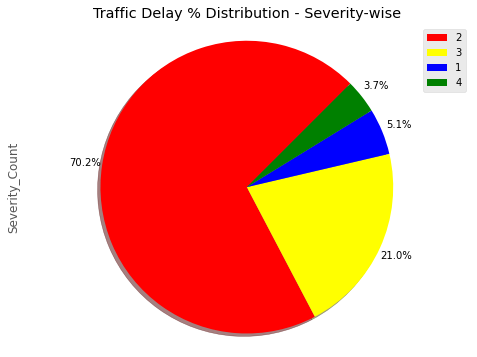

In [38]:
colors_list = ['red', 'yellow','blue','green']
explode_list = [0, 0, 0, 0] # ratio for each continent with which to offset each wedge.

df_sev_grp_all['Severity_Count'].plot(kind='pie',
                            figsize=(8, 6),
                            autopct='%1.1f%%', 
                            startangle=45,    
                            shadow=True,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list,  # add custom colors
                            explode=explode_list # 'explode' lowest 3 continents
                            )

# scale the title up by 12% to match pctdistance
plt.title('Traffic Delay % Distribution - Severity-wise') 

plt.axis('equal') 

# add legend
plt.legend(labels=df_sev_grp_all.index, loc='upper right') 

plt.show()

In [39]:
df_grp_state = df_us_acc.groupby(['State']).agg(Severity_Count = ('Severity','count')).reset_index().sort_values('Severity_Count', ascending=False)
df_grp_state = df_grp_state[['Severity_Count','State']].set_index('State')
#df_grp_state_fil =df_grp_state[df_grp_state['Severity_Count']>5000]
df_grp_state_fil = df_grp_state
df_grp_state_fil.count()

Severity_Count    49
dtype: int64

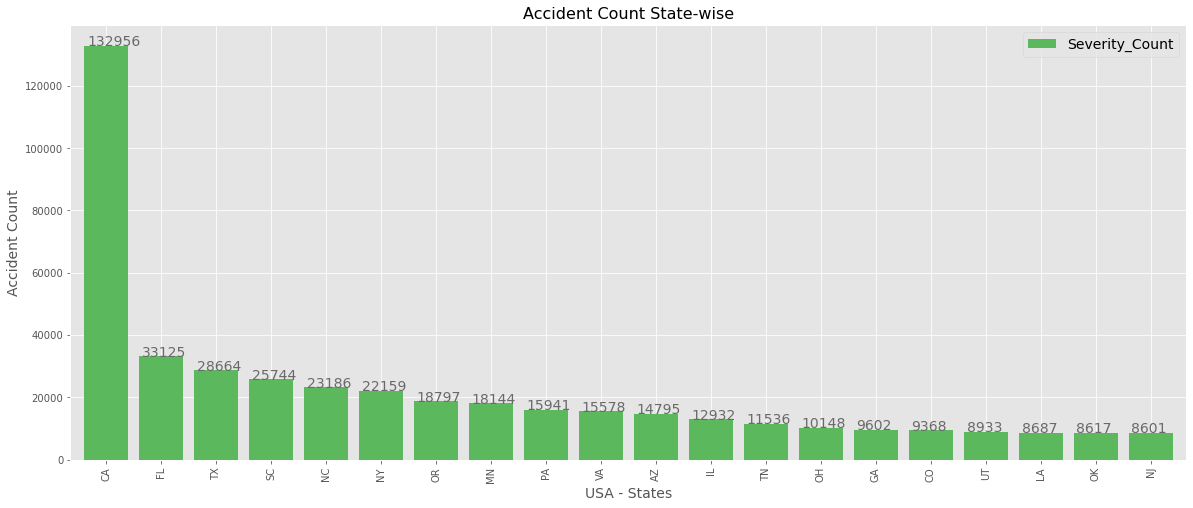

In [40]:
%matplotlib inline 
import matplotlib as mpl
#ds_srvy_df.sort_values(by='Very interested', ascending=False, inplace=True)
df_per = round(df_grp_state.div(df_grp_state.sum(1), axis=0)*100,2)

ax=df_grp_state_fil.head(20).plot(kind='bar',  stacked=False, figsize=(20,8), width=.8, color=[ '#5cb85c', '#5bc0de', '#d9534f'])
ax.set_title("Accident Count State-wise", fontsize="16")
ax.set_xlabel("USA - States", fontsize=14)
ax.set_ylabel("Accident Count", fontsize=14)
ax.legend(prop={"size":14})

for i in ax.patches:
    ax.text(i.get_x()+.05, i.get_height()+1.5, \
            str(i.get_height()), fontsize=14,
                color='dimgrey')


In [14]:
df_grp_state.head()

,Severity_Count
State,
CA,132956
FL,33125
TX,28664
SC,25744
NC,23186


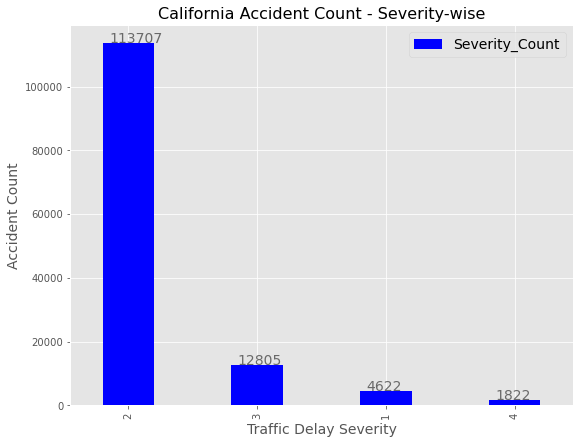

In [41]:
df_ca = df_us_acc[df_us_acc['State']=='CA']
df_ca_grp = df_ca.groupby(['Severity']).agg(Severity_Count = ('Severity','count')).reset_index().sort_values('Severity_Count', ascending=False)
df_ca_grp = df_ca_grp[['Severity_Count','Severity']].set_index('Severity')
df_per = round(df_grp_state.div(df_grp_state.sum(1), axis=0)*100,2)

ax=df_ca_grp.plot(kind='bar',  stacked=False, figsize=(9, 7), width=.4, color='blue')
ax.set_title("California Accident Count - Severity-wise", fontsize="16")
ax.set_xlabel("Traffic Delay Severity", fontsize=14)
ax.set_ylabel("Accident Count", fontsize=14)
ax.legend(prop={"size":14})

for i in ax.patches:
    ax.text(i.get_x()+.05, i.get_height()+1.5, \
            str(i.get_height()), fontsize=14,
                color='dimgrey')

Text(0.5, 1.0, 'California State - Traffic Delay - Severitywise')

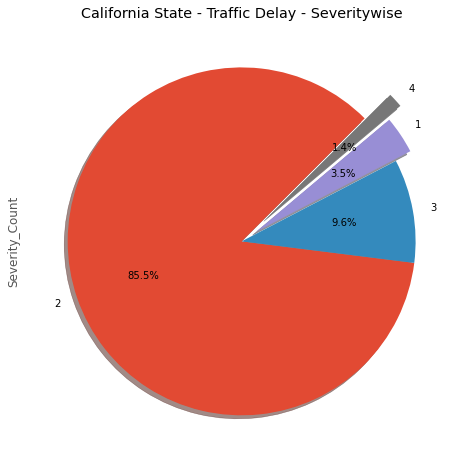

In [42]:
df_ca_grp['Severity_Count'].plot(kind='pie',
                            figsize=(12, 8),
                            autopct='%1.1f%%', # add in percentages
                            startangle=45,     
                            shadow=True,       # add shadow      
                            explode=[0,0,0.1,0.2]
                            )
plt.title('California State - Traffic Delay - Severitywise')

Analyze Traffice Delay Impact with Severity 4 and 3

In [43]:
df_grp_city = df_us_acc.groupby(['Severity','State','City']).agg(Severity_Count = ('Severity','count')).reset_index().sort_values('Severity_Count', ascending=True)
df_Sev4 = df_grp_city[(df_grp_city['Severity']==4) & (df_grp_city['Severity_Count']>=100)].reset_index(drop=True)
df_Sev4 = df_Sev4[['City','Severity_Count']].sort_values('Severity_Count',ascending=False).set_index('City')


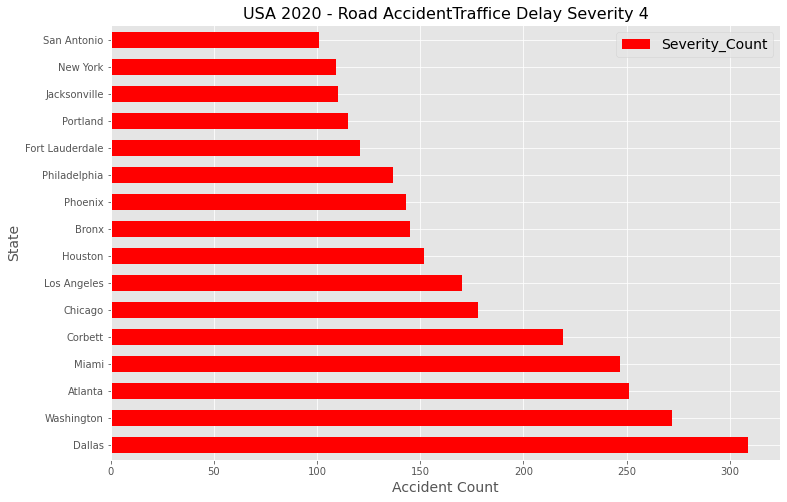

In [44]:

ax=df_Sev4.plot(kind='barh',  stacked=False, figsize=(12,8), width=.6,  color='red') #color=[ '#5cb85c', '#5bc0de', '#d9534f']
ax.set_title("USA 2020 - Road AccidentTraffice Delay Severity 4", fontsize="16")
ax.set_xlabel("Accident Count", fontsize=14)
ax.set_ylabel("State", fontsize=14)
ax.legend(prop={"size":14})



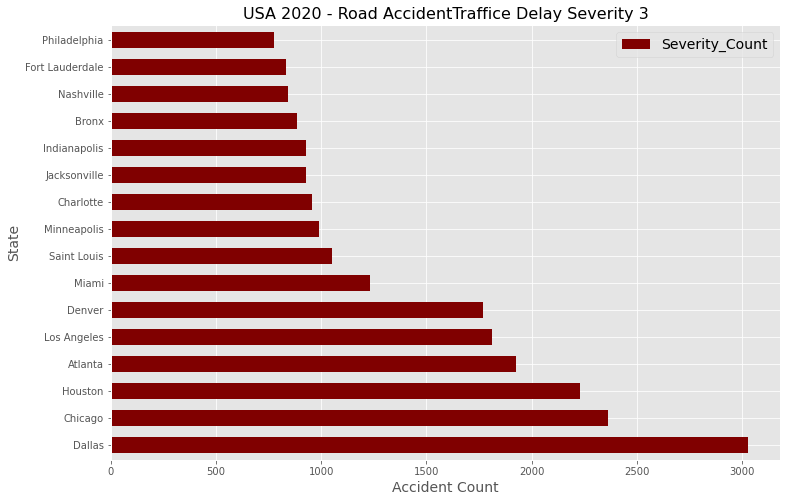

In [46]:
df_Sev3 = df_grp_city[(df_grp_city['Severity']==3) & (df_grp_city['Severity_Count']>=500)].reset_index(drop=True)
df_Sev3 = df_Sev3[['City','Severity_Count']].sort_values('Severity_Count',ascending=False).set_index('City')
ax=df_Sev3.head(16).plot(kind='barh',  stacked=False, figsize=(12,8), width=.6,  color='maroon') #color=[ '#5cb85c', '#5bc0de', '#d9534f']
ax.set_title("USA 2020 - Road AccidentTraffice Delay Severity 3", fontsize="16")
ax.set_xlabel("Accident Count", fontsize=14)
ax.set_ylabel("State", fontsize=14)
ax.legend(prop={"size":14})

(96, 3)


<AxesSubplot:xlabel='Severity', ylabel='Accident_Hour'>

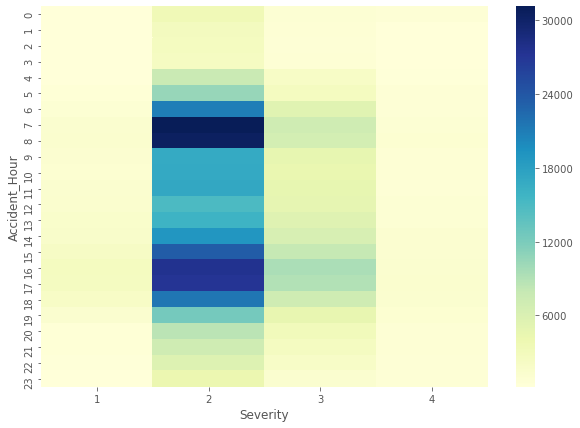

In [47]:

df_hr_cnt = df_us_acc.groupby(['Start_Hr_Min','Severity']).agg(severity_count_by_Hr=('Severity', 'count')).reset_index().sort_values('severity_count_by_Hr',ascending=False).reset_index(drop=True)
print(df_hr_cnt.shape)

df_hr_cnt_hm = df_hr_cnt[['Start_Hr_Min','Severity','severity_count_by_Hr']]
df_hr_cnt_hm.rename(columns={'Start_Hr_Min':'Accident_Hour'},inplace=True)
df_hr_cnt_hm.head(5)
#df_heat_map = pd.pivot_table(df_hr_cnt_hm, values='Severity', index=['Start_Hr_Min'], columns='severity_count_by_Hr')
df_heat_map = pd.pivot_table(df_hr_cnt_hm, values='severity_count_by_Hr', index=['Accident_Hour'], columns='Severity')
plt.subplots(figsize=(10,7))
sns.heatmap(df_heat_map, cmap="YlGnBu",linewidths=0)

The relationship between severity and Temperature

In [48]:
df_tmpr = df_us_acc.groupby(['Temperature','Severity']).agg(Sev_Vs_Temp=('Severity','count')).sort_values('Severity',ascending=False)
df_tmpr

,,Sev_Vs_Temp
Temperature,Severity,
89.0,4,97
46.0,4,367
97.0,4,14
47.0,4,259
18.0,4,32
...,...,...
42.0,1,120
82.0,1,609
43.0,1,121


In [49]:
dp_tmpr_bins = pd.qcut(df_us_acc['Temperature'],6)
dp_tmpr_bins.head()

0     (60.0, 68.0]
1     (60.0, 68.0]
2    (77.0, 113.0]
3     (53.0, 60.0]
4     (43.0, 53.0]
Name: Temperature, dtype: category
Categories (6, interval[float64]): [(-27.001, 43.0] < (43.0, 53.0] < (53.0, 60.0] < (60.0, 68.0] < (68.0, 77.0] < (77.0, 113.0]]

In [57]:
def tempr_binning(tempratue_value):
    rec = int( tempratue_value)
    if (rec < -10):
        return "Below -10"
    elif (rec > -10 and rec <= 0):
        return "0 to -10"
    elif (rec > 0 and rec <= 10):
        return "0 to 10"
    elif (rec > 10 and rec <= 20):
        return "10 to 20"
    elif (rec > 20 and rec <= 30):
        return "20 to 30"
    elif rec > 30 and rec <= 50 :
        return "30 to 50"
    elif rec > 50 and rec < 80 :
        return "50 to 80"
    else:
        return "Above 80"
    
def visibility_binning(visibility):
    vis = int(visibility)
    if(vis <= 1):
        return 1
    elif vis >1 and vis <=3:
        return 3
    elif vis >3 and vis <=6:
        return 6
    elif vis > 6 :
        return 10
    
        
print(tempr_binning(30))

20 to 30


In [58]:
#df_us_acc['Temperature_Range'] = df_us_acc.apply(lamda df_us_acc[])
df_us_acc['Temperature_Range'] = df_us_acc.apply(lambda x: tempr_binning(x.Temperature), axis=1)
df_us_acc['Visibility'] =  df_us_acc.apply(lambda x: visibility_binning(x.Visibility), axis=1) 

In [52]:
df_us_acc['Temperature_Range'].value_counts()

40 to 80     330482
Above 80     141390
0 to 40       27961
0 to -10        685
Below -10        91
Name: Temperature_Range, dtype: int64

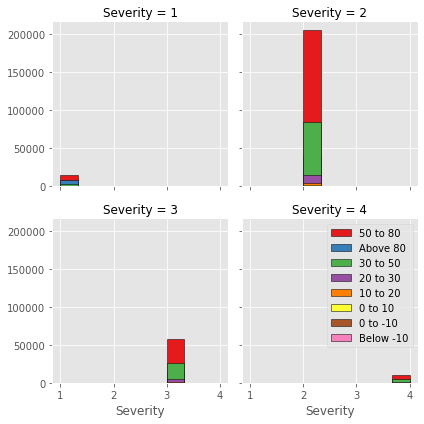

In [59]:
import seaborn as sns

bins = np.linspace(df_us_acc.Severity.min(), df_us_acc.Severity.max(), 10)
g = sns.FacetGrid(df_us_acc, col="Severity", hue="Temperature_Range", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Severity', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

In [30]:
list(np.ceil(df_us_acc['Visibility'] .unique()))

[10.0, 6.0, 1.0, 3.0]

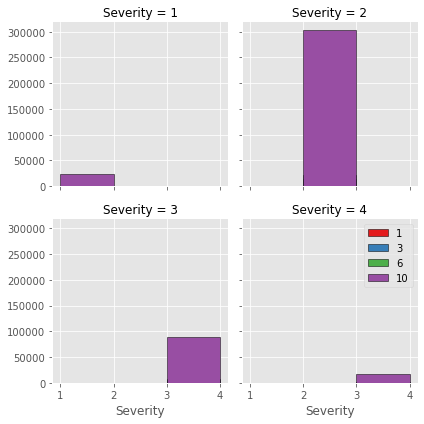

In [60]:
bins = np.linspace(df_us_acc.Severity.min(), df_us_acc.Severity.max(), 4)
g = sns.FacetGrid(df_us_acc, col="Severity", hue="Visibility", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Severity', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

In [21]:
df_others = df_us_acc.groupby(['Severity','Start_Hr_Min']).agg(Crossing=('Crossing','sum'), Junction=('Junction','sum'), Roundabout=('Roundabout','sum'), Stop=('Stop','sum'),Bump=('Bump','sum') ).reset_index()
df_others

,Severity,Start_Hr_Min,Crossing,Junction,Roundabout,Stop,Bump
0,1,0,40,57,0,6,0
1,1,1,28,37,0,3,0
2,1,2,25,44,0,7,0
3,1,3,25,36,0,4,2
4,1,4,51,41,0,6,2
...,...,...,...,...,...,...,...
91,4,19,60,94,0,11,0
92,4,20,52,70,0,4,0
93,4,21,71,60,0,9,0
94,4,22,51,47,0,5,0


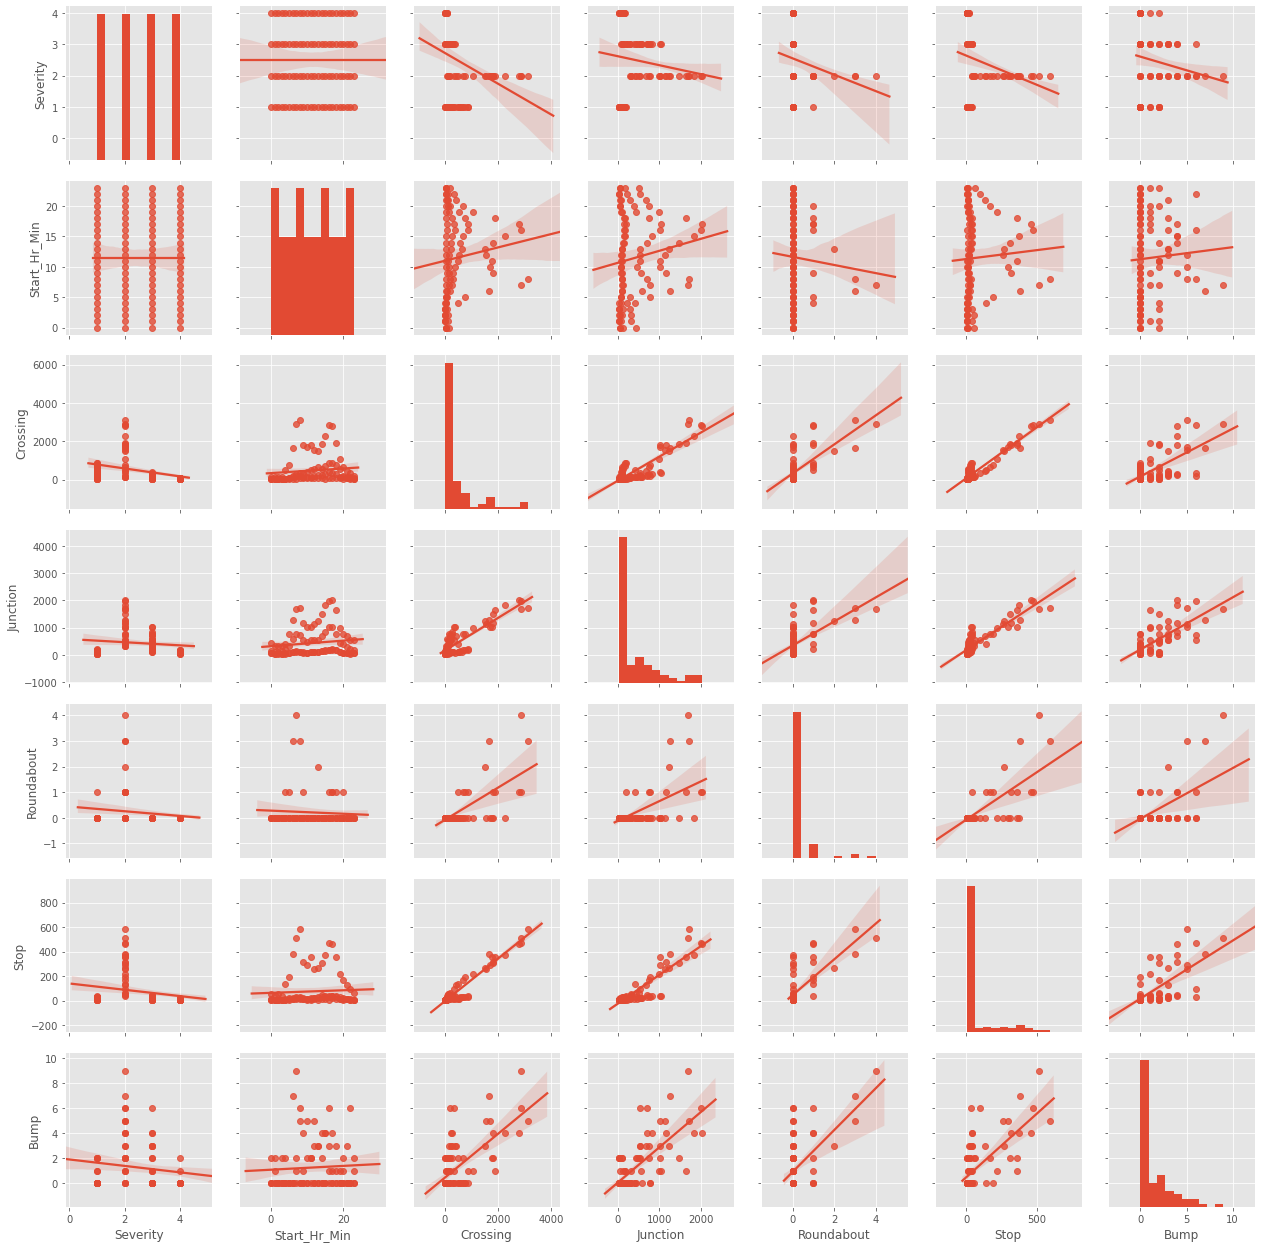

In [22]:
# with regression
sns.pairplot(df_others, kind="reg")
plt.show()
 


In [43]:
df_others

,Severity,Start_Hr_Min,crossing_count,junction_count,roundabout_count,stop_count,bump_count
0,1,0,40,57,0,6,0
1,1,1,28,37,0,3,0
2,1,2,25,44,0,7,0
3,1,3,25,36,0,4,2
4,1,4,51,41,0,6,2
...,...,...,...,...,...,...,...
91,4,19,60,94,0,11,0
92,4,20,52,70,0,4,0
93,4,21,71,60,0,9,0
94,4,22,51,47,0,5,0


## Feature Selection

In [17]:
Feature = df_us_acc[['Temperature', 'Start_Hr_Min',  'Wind_Chill', 'Humidity','Pressure', 'Visibility', 'Wind_Speed','Precipitation', 'Bump', 'Crossing','Junction', 'Roundabout', 'Stop']]

Feature = pd.concat([Feature, pd.get_dummies(df_us_acc['Wind_Direction']), pd.get_dummies(df_us_acc['Weather_Condition'])], axis=1)


y = df_us_acc['Severity']

Feature.head()

,Temperature,Start_Hr_Min,Wind_Chill,Humidity,Pressure,Visibility,Wind_Speed,Precipitation,Bump,Crossing,...,Snow / Windy,Squalls / Windy,T-Storm,T-Storm / Windy,Thunder,Thunder / Windy,Thunder in the Vicinity,Widespread Dust,Wintry Mix,Wintry Mix / Windy
0,67.0,4,67.0,70.0,29.84,10.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,59.0,10,59.0,58.0,29.93,10.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,35.0,13,35.0,82.0,29.16,3.0,3.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,57.0,18,57.0,40.0,29.85,10.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,82.0,13,82.0,23.0,28.70,5.0,8.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Feature Scaling

We must normaliza the data before training the model to get more accurate results. 

In [6]:
from sklearn import preprocessing
Feature = preprocessing.StandardScaler().fit(Feature).transform(Feature)
Feature

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


array([[ 0.42377742, -1.60566832,  0.44478344, ..., -0.00632468,
        -0.04053016, -0.00894463],
       [-0.03144323, -0.461704  ,  0.03881467, ..., -0.00632468,
        -0.04053016, -0.00894463],
       [-1.39710517,  0.11027816, -1.17909163, ..., -0.00632468,
        -0.04053016, -0.00894463],
       ...,
       [ 0.42377742, -0.461704  ,  0.44478344, ..., -0.00632468,
        -0.04053016, -0.00894463],
       [-0.08834581, -0.27104328, -0.01193142, ..., -0.00632468,
        -0.04053016, -0.00894463],
       [-0.03144323,  1.4449032 ,  0.03881467, ..., -0.00632468,
        -0.04053016, -0.00894463]])

In [7]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn import metrics


## Train Test Split

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( Feature, y, test_size=0.2, random_state=4)


# Model Building

## Decision Tree

In [10]:
from sklearn.tree import DecisionTreeClassifier

severityTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)

severityTree.fit(X_train, y_train)

predSeverityTree = severityTree.predict(X_test)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predSeverityTree))
dt_Jaccard = jaccard_similarity_score(y_test, predSeverityTree)
print("DecisionTrees's Jaccard Score : {}".format(dt_Jaccard))
dt_f1_score = f1_score(y_test, predSeverityTree, average='weighted') 
print("DecisionTrees's F1-Score : {}".format(dt_f1_score))

DecisionTrees's Accuracy:  0.7108
DecisionTrees's Jaccard Score : 0.7108
DecisionTrees's F1-Score : 0.6011697629081277


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression(C=0.01, solver='liblinear', multi_class='auto').fit(X_train,y_train)
predLogSeverity = LogReg.predict(X_test)
print("Logistic Regression's Accuracy: ", metrics.accuracy_score(y_test, predLogSeverity))
yprob = LogReg.predict_proba(X_test)
ll_log_loss = log_loss(y_test, yprob)
print("Logistic Regression's Log Loss : {}".format(ll_log_loss))

ll_Jaccard = jaccard_similarity_score(y_test, predLogSeverity)
print("Logistic Regression's Jaccard Score : {}".format(ll_Jaccard))
ll_f1_score = f1_score(y_test, predLogSeverity, average='weighted') 
print("Logistic Regression's F1-Score : {}".format(ll_f1_score))

Logistic Regression's Accuracy:  0.7054
Logistic Regression's Log Loss : 0.8112005835203803
Logistic Regression's Jaccard Score : 0.7054
Logistic Regression's F1-Score : 0.5878045267320173


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## K Nearest Neighbor(KNN)

In [14]:
from sklearn.neighbors import KNeighborsClassifier

[0.67509638 0.69214558 0.67467689 0.69168614 0.68738139 0.69390344
 0.6922155 ]


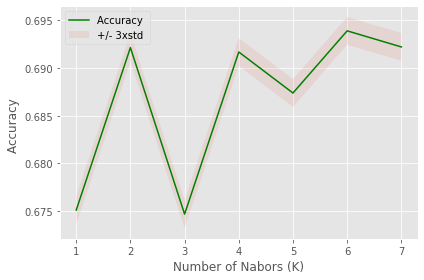

The best accuracy was with 0.6939034378058768 with k= 6


In [64]:

Ks = 8
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train, y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

print(mean_acc)

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 


In [16]:
k=6

neigh = KNeighborsClassifier(n_neighbors = k, ).fit(X_train, y_train)
predKNNSeverity = neigh.predict(X_test)


knn_Jaccard = jaccard_similarity_score(y_test, predKNNSeverity)
print("Decision Tree's Jaccard Score : {}".format(knn_Jaccard))
knn_f1_score = f1_score(y_test, predKNNSeverity, average='weighted') 
print("Decision Tree's F1-Score : {}".format(knn_f1_score))

Decision Tree's Jaccard Score : 0.6889
Decision Tree's F1-Score : 0.6223328075071991


## Support Vector Machine

In [12]:
from sklearn import svm
severitySvm = svm.SVC(kernel='rbf', gamma='auto')
severitySvm.fit(X_train,  y_train)
predSvmSeverity = severitySvm.predict(X_test)

print("SVM's Accuracy: ", metrics.accuracy_score(y_test, predSvmSeverity))
svm_Jaccard = jaccard_similarity_score(y_test, predSvmSeverity)
print("Support Vector Machine's Jaccard Score : {}".format(ll_Jaccard))
svm_f1_score = f1_score(y_test, predSvmSeverity, average='weighted') 
print("Support Vector Machine's F1-Score : {}".format(svm_f1_score))

SVM's Accuracy:  0.7074
Support Vector Machine's Jaccard Score : 0.7054
Support Vector Machine's F1-Score : 0.5932483706319823


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
